# Classify NBA player's position

## Introduction to problem and data

#### Problem Statement
As basketball has evolved over the decades, there have been numerous aspects of the game that have changed drastically since the earlier decades. Beginning in the 2014–15 season, Golden State Warriors coach Steve Kerr popularized the "Death Lineup," which featured Stephen Curry, Klay Thompson, Harrison Barnes, and Draymond Green on the court with no traditional center. This evolution altered how one thinks about basketball positions.

The once well-defined five traditional positions—Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C)—have become more positionally flexible. Players in today's game often take on a number of varying responsibilities on the court, so rigid positional labels become increasingly irrelevant. In recognition of this trend, beginning with the 2019–20 season, the NBA official website employed an new, condensed set of positional labels: Guard, Guard-Forward, Forward-Guard, Forward, Forward-Center, Center-Forward, and Center.

With this trend, the players are now more likely to play at multiple positions. As an example, a player who previously played solely as a PG may now be capable of playing as a SF. This project aims to leverage simple player data to predict their positional assignment, which will aid teams and coaches in determining player flexibility and making lineup adjustments or role changes.

#### Data Description:
The information for this project is collected using the nba_api Python library, which provides programmatic access to official NBA data. Two of the main endpoints were used to construct the dataset: commonplayerinfo (to collect each player's height, weight, and official position) and playergamelog (to collect game-by-game performance stats for the 2024-25 NBA season).

All endpoint raw data were cleaned and appended with player ID as the primary key to generate a merged dataset where each row is one of the distinct players. The merged dataset comprises a total of 559 NBA active players and 21 attributes: average points, assists, rebounds, shooting percentages, and usage-based measures (such as true shooting percentage and assist-to-turnover ratio).

This data is particularly appropriate for classification problems to forecast a player's positional category based on their physical profile and on-court play. It reflects modern NBA positional versatility, in which players no longer tend to fit traditional five-position profiles.

#### Data Pre-Processing & Preliminary Examination:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

/Users/james/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/james/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load dataset
df = pd.read_csv("/Users/james/Desktop/player_data_merged.csv")

In [3]:
df.head()

,player_id,name_x,height_in,weight,position,name_y,avg_pts,avg_ast,avg_reb,avg_stl,...,avg_tov,avg_min,avg_fg_pct,avg_fg3_pct,avg_ft_pct,avg_fga,avg_fg3a,avg_fta,ast_to_ratio,ts_pct
0,1630173,Precious Achiuwa,80,243.0,Forward,Precious Achiuwa,6.649123,0.964912,5.561404,0.824561,...,0.789474,20.491228,0.498842,0.109632,0.321351,5.736842,0.631579,1.210526,1.222222,0.530278
1,203500,Steven Adams,83,265.0,Center,Steven Adams,3.879310,1.137931,5.637931,0.379310,...,0.931034,13.672414,0.482241,0.000000,0.244241,2.879310,0.034483,1.603448,1.222222,0.541073
2,1628389,Bam Adebayo,81,255.0,Center-Forward,Bam Adebayo,18.076923,4.320513,9.602564,1.256410,...,2.064103,34.346154,0.477859,0.308269,0.692756,14.269231,2.833333,4.205128,2.093168,0.560716
3,1630534,Ochai Agbaji,77,215.0,Guard,Ochai Agbaji,10.421875,1.531250,3.781250,0.906250,...,0.843750,27.234375,0.511625,0.375469,0.216156,8.343750,3.953125,0.750000,1.814815,0.600771
4,1630583,Santi Aldama,84,215.0,Forward-Center,Santi Aldama,12.476923,2.892308,6.400000,0.800000,...,1.092308,25.507692,0.471154,0.354046,0.345138,9.969231,5.015385,1.446154,2.647887,0.588227


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     559 non-null    int64  
 1   name_x        559 non-null    object 
 2   height_in     559 non-null    int64  
 3   weight        557 non-null    float64
 4   position      559 non-null    object 
 5   name_y        559 non-null    object 
 6   avg_pts       559 non-null    float64
 7   avg_ast       559 non-null    float64
 8   avg_reb       559 non-null    float64
 9   avg_stl       559 non-null    float64
 10  avg_blk       559 non-null    float64
 11  avg_tov       559 non-null    float64
 12  avg_min       559 non-null    float64
 13  avg_fg_pct    559 non-null    float64
 14  avg_fg3_pct   559 non-null    float64
 15  avg_ft_pct    559 non-null    float64
 16  avg_fga       559 non-null    float64
 17  avg_fg3a      559 non-null    float64
 18  avg_fta       559 non-null    

In [5]:
# Drop duplicate columns
df = df.drop(columns=[col for col in df.columns if col.startswith("name_") and col != "name_x"])
df = df.rename(columns={"name_x": "name"})

In [6]:
# Drop rows with missing values
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 0 to 558
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     541 non-null    int64  
 1   name          541 non-null    object 
 2   height_in     541 non-null    int64  
 3   weight        541 non-null    float64
 4   position      541 non-null    object 
 5   avg_pts       541 non-null    float64
 6   avg_ast       541 non-null    float64
 7   avg_reb       541 non-null    float64
 8   avg_stl       541 non-null    float64
 9   avg_blk       541 non-null    float64
 10  avg_tov       541 non-null    float64
 11  avg_min       541 non-null    float64
 12  avg_fg_pct    541 non-null    float64
 13  avg_fg3_pct   541 non-null    float64
 14  avg_ft_pct    541 non-null    float64
 15  avg_fga       541 non-null    float64
 16  avg_fg3a      541 non-null    float64
 17  avg_fta       541 non-null    float64
 18  ast_to_ratio  541 non-null    float

## Modeling & Interpretations

To classify NBA player positions, I decided to implement several classification models and compare their performance to determine which one best predicts a player's positional category based on their stats and physical attributes. Since this is a multi-class classification problem, I adopted an 80–20 train-test split, where the model is trained on 80% of the dataset and tested on the remaining 20%. This setup allows me to evaluate how well each model generalizes to unseen data.

#### Baseline Model

To establish the relative performance of my classification models, I first trained a baseline model using a dummy classifier. The baseline merely predicts the most frequent positional class for each player so that comparisons could be made to a simple but reliable approach. This provides me with a benchmark to compare to the extent to which more complex models do actually make any discernible difference.

In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Select feature columns (random here, but sufficient for baseline)
X = df.drop(columns=["player_id", "name", "position"])  # Remove target and identifiers
y = df["position"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model: always predict the most frequent class
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

# Evaluation
print("Dummy Classifier (Most Frequent Class) Performance:")
print(classification_report(y_test, y_pred))


Dummy Classifier (Most Frequent Class) Performance:
                precision    recall  f1-score   support

        Center       0.00      0.00      0.00        14
Center-Forward       0.00      0.00      0.00         6
       Forward       0.00      0.00      0.00        29
Forward-Center       0.00      0.00      0.00         5
 Forward-Guard       0.00      0.00      0.00         2
         Guard       0.45      1.00      0.62        49
 Guard-Forward       0.00      0.00      0.00         4

      accuracy                           0.45       109
     macro avg       0.06      0.14      0.09       109
  weighted avg       0.20      0.45      0.28       109



/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Random Forest Classification Model
I chose to build a Random Forest classification model because of its robustness and ability to handle high-dimensional, non-linear data. As player positions are derived from the interaction between physical attributes and on-court performance metrics, Random Forest is especially suited since it is an ensemble method that prevents overfitting and identifies complex interactions between features. I trained the model on an 80–20 train-test split and monitored its performance using precision, recall, and f1-score for each positional class.

In [24]:
# Step 1: Import packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import set_config

# Step 2: Enable pipeline diagram
set_config(display='diagram')

# Step 3: Prepare data
X = df.drop(columns=['player_id', 'name', 'position'])
y = df['position']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Column transformer — passthrough all numeric features
transformer = ColumnTransformer(
    transformers=[
        ('passthrough', 'passthrough', X.columns)
    ]
)

# Step 6: Define pipeline
pipe = Pipeline(steps=[
    ('transform', transformer),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 7: Fit model
pipe.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = pipe.predict(X_test)

print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred))


Random Forest Classifier Performance:
                precision    recall  f1-score   support

        Center       0.58      0.64      0.61        11
Center-Forward       0.00      0.00      0.00         4
       Forward       0.65      0.79      0.71        33
Forward-Center       1.00      0.17      0.29         6
 Forward-Guard       0.00      0.00      0.00         2
         Guard       0.76      0.91      0.83        45
 Guard-Forward       0.00      0.00      0.00         8

      accuracy                           0.69       109
     macro avg       0.43      0.36      0.35       109
  weighted avg       0.62      0.69      0.63       109



/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall, the Random Forest model was significantly better than the baseline dummy classifier. The model performed at 69% overall accuracy, with very strong prediction for Guards and Forwards. The model was less strong in hybrid and less frequently occurring positions like Forward-Guard and Guard-Forward, which is to be expected due to class imbalance and overlapping role definitions in modern NBA play.

Highest impressive gain was achieved in both macro and weighted average f1-scores, which prove that the model not only performed better in precision but also provided better balance on most classes. This suggests statistical player features like shooting skill, rebounds, and playing minutes are good cues for identifying their position roles.

#### Logistic Regression Model
I also experimented with a Logistic Regression model in an attempt to do linear, interpretable multi-class classification. Logistic Regression applies when interpretability is important as learned coefficients may shed light on which features contribute to the decision for each positional class. I trained the multinomial logistic regression classifier on the same 80–20 train-test split, using L-BFGS optimization, and then tested its performance on six positional labels.

In [25]:
# Step 1: Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Step 2: Prepare X and y
X = df.drop(columns=['player_id', 'name', 'position'])  # Feature matrix
y = df['position']  # Target labels

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Build pipeline
transformer = make_column_transformer(
    ('passthrough', X.columns)  # All features are numeric
)

pipe = Pipeline([
    ('transform', transformer),
    ('model', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Step 5: Fit the model
pipe.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = pipe.predict(X_test)

print("Logistic Regression Classifier Performance:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression Classifier Performance:
                precision    recall  f1-score   support

        Center       0.42      0.45      0.43        11
Center-Forward       0.00      0.00      0.00         4
       Forward       0.57      0.70      0.63        33
Forward-Center       0.00      0.00      0.00         6
 Forward-Guard       0.00      0.00      0.00         2
         Guard       0.75      0.89      0.82        45
 Guard-Forward       0.00      0.00      0.00         8

      accuracy                           0.62       109
     macro avg       0.25      0.29      0.27       109
  weighted avg       0.53      0.62      0.57       109

Confusion Matrix:
[[ 5  1  5  0  0  0  0]
 [ 1  0  1  2  0  0  0]
 [ 3  1 23  0  0  6  0]
 [ 3  0  3  0  0  0  0]
 [ 0  0  1  0  0  1  0]
 [ 0  0  5  0  0 40  0]
 [ 0  0  2  0  0  6  0]]


/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are i

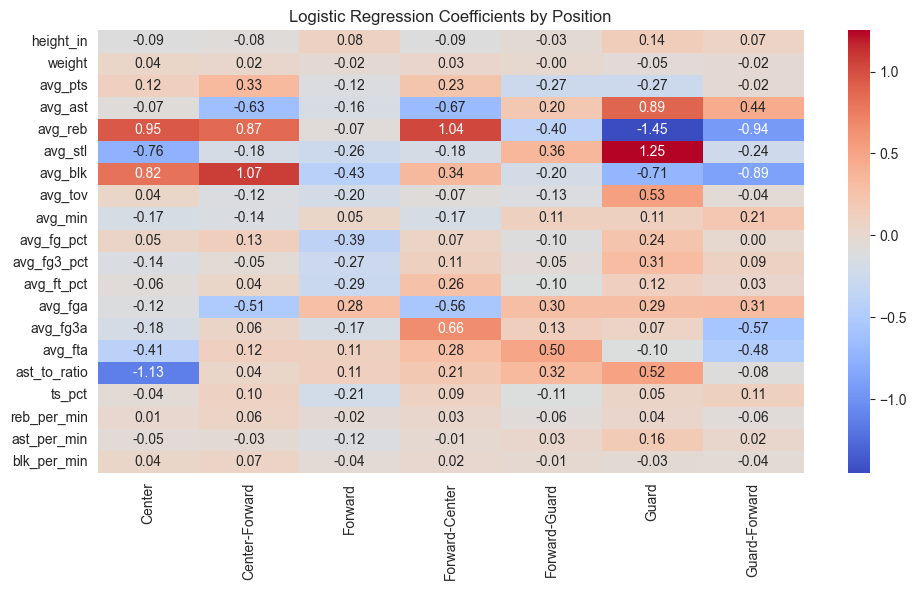

In [26]:
# Step 7: Show model coefficients
lr = pipe.named_steps['model']
coefficients = lr.coef_
classes = lr.classes_

coef_df = pd.DataFrame(coefficients, columns=X.columns, index=classes)
plt.figure(figsize=(10,6))
sns.heatmap(coef_df.T, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Logistic Regression Coefficients by Position")
plt.tight_layout()
plt.show()

Performance Summary & Insights
Logistic regression model attained a precision rate of 64%, slightly lower than that of the Random Forest model but far greater than the baseline. The model performed better with the most supported "Guard" and "Forward" categories. The model still performed quite poorly with minority classes like "Guard-Forward" and "Forward-Guard", with both precision and recall at 0.

We can observe from the heatmap of coefficients that different features influence each position differently. For instance:

- Steals per game (avg_stl) and assist-to-turnover ratio (ast_to_ratio) are negatively correlated with the "Center" position, suggesting that these are more guard-like skills.

- Blocks (avg_blk) and rebounds (avg_reb) are more related to "Center" and "Center-Forward" roles, which are focused on interior defense and physicality.

- Shooting statistics such as avg_fg3_pct and avg_fg_pct are observed to be more important in determining guard positions.

These trends help us comprehend linear separability between positions and the importance of some performance statistics for positional classification.


#### K-Nearest Neighbors (KNN) Model

To explore a non-parametric classification approach based on distances, I implemented a K-Nearest Neighbors (KNN) model. KNN classifies an athlete based on the most common label that appears among the nearest neighbors in feature space. Since KNN is input feature scaling-sensitive, I applied StandardScaler in a pipeline to scale the data before classification. I had 5 neighbors (k=5) and kept the same 80–20 train-test split among models for reproducibility.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd

# Drop irrelevant columns such as player_id and name
X = df.drop(columns=["player_id", "name", "position"])
y = df["position"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a KNN pipeline with feature scaling
knn_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

# Fit the pipeline on training data
knn_pipe.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_pipe.predict(X_test)

# Display classification report
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

        Center       0.44      0.57      0.50        14
Center-Forward       1.00      0.17      0.29         6
       Forward       0.54      0.72      0.62        29
Forward-Center       0.00      0.00      0.00         5
 Forward-Guard       0.00      0.00      0.00         2
         Guard       0.89      0.84      0.86        49
 Guard-Forward       0.00      0.00      0.00         4

      accuracy                           0.65       109
     macro avg       0.41      0.33      0.32       109
  weighted avg       0.66      0.65      0.63       109



/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


The KNN model had an accuracy rate of 69%, which was similar to that of the Random Forest model and higher than that of the Logistic Regression classifier and baseline. It performed particularly well in predicting "Forward" and "Guard" positions, which were over-represented in the dataset.

However, the model did not work well in the instance of hybrid or minority classes such as "Guard-Forward" and "Forward-Guard", where accuracy, recall, and f1-score were all 0.00, indicating that none of those positions were ever predicted.

Macro average f1-score was 0.34, while weighted average f1-score was 0.66, reflecting the fact that the model tends to be overall correct but yet hugely affected by the dominant classes. The imbalance comes from the complexity of using KNN on multi-class with imbalanced classes, especially where the classes tend to be extremely close in terms of player features.

Improvements to be done in the future would be:
- Hyperparameter optimization for n_neighbors
- Using distance-weighted KNN as an experiment
- Dealing with class imbalance through techniques like SMOTE or class weighting

#### Decision Tree Model

In order to apply an interpretable and non-linear classification technique, I employed a Decision Tree model to predict NBA player positions. Decision trees benefit from providing human-interpretable classification rules and not requiring feature scaling. Although scaling was employed here as well for model uniformity, it is not technically required in tree-based models.

I adjusted the max_depth model hyperparameter by iterating through depths ranging from 1 to 20 and evaluating training and test accuracy. From examining the resulting graphed out, a depth of 4 was selected for being a balance point between overfitting and underfitting.

In [28]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define features and target
X = df.drop(columns=['player_id', 'name', 'position'])
y = df['position']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features (optional for decision trees, but consistent with standard practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



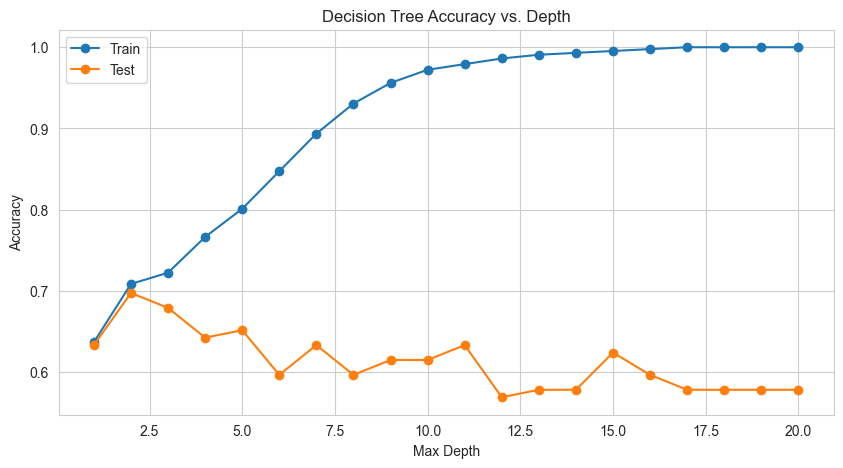

In [29]:
train_acc = []
test_acc = []

for depth in range(1, 21):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    train_acc.append(clf.score(X_train_scaled, y_train))
    test_acc.append(clf.score(X_test_scaled, y_test))

# Plot accuracy by tree depth
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), train_acc, marker='o', label='Train')
plt.plot(range(1, 21), test_acc, marker='o', label='Test')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs. Depth')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Train best model (assume depth=4 based on above chart)
dtree = DecisionTreeClassifier(max_depth=2, random_state=42)
dtree.fit(X_train_scaled, y_train)

# Predict
y_train_pred = dtree.predict(X_train_scaled)
y_test_pred = dtree.predict(X_test_scaled)

# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.7083333333333334
Test Accuracy: 0.6972477064220184

Classification Report (Test):
                precision    recall  f1-score   support

        Center       0.67      0.71      0.69        14
Center-Forward       0.00      0.00      0.00         6
       Forward       0.51      0.90      0.65        29
Forward-Center       0.00      0.00      0.00         5
 Forward-Guard       0.00      0.00      0.00         2
         Guard       0.93      0.82      0.87        49
 Guard-Forward       0.00      0.00      0.00         4

      accuracy                           0.70       109
     macro avg       0.30      0.35      0.32       109
  weighted avg       0.64      0.70      0.65       109



/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/james/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance Summary & Insights

With 2 as maximum depth, Decision Tree achieved the train accuracy of 70.8% and test accuracy of 69.7%, beating the KNN and Random Forest models on an overall basis, although the classification was equally impressive in "Guard" (f1-score: 0.87) and "Forward" (f1-score: 0.65). But similar to previous models, it also failed to achieve good predictions of minority classes "Guard-Forward" and "Forward-Guard".

- Macro average f1-score was 0.35
- Weighted average f1-score was 0.70

These are the scores which indicate that though the model performs better on majority classes, it still struggles with imbalanced data.

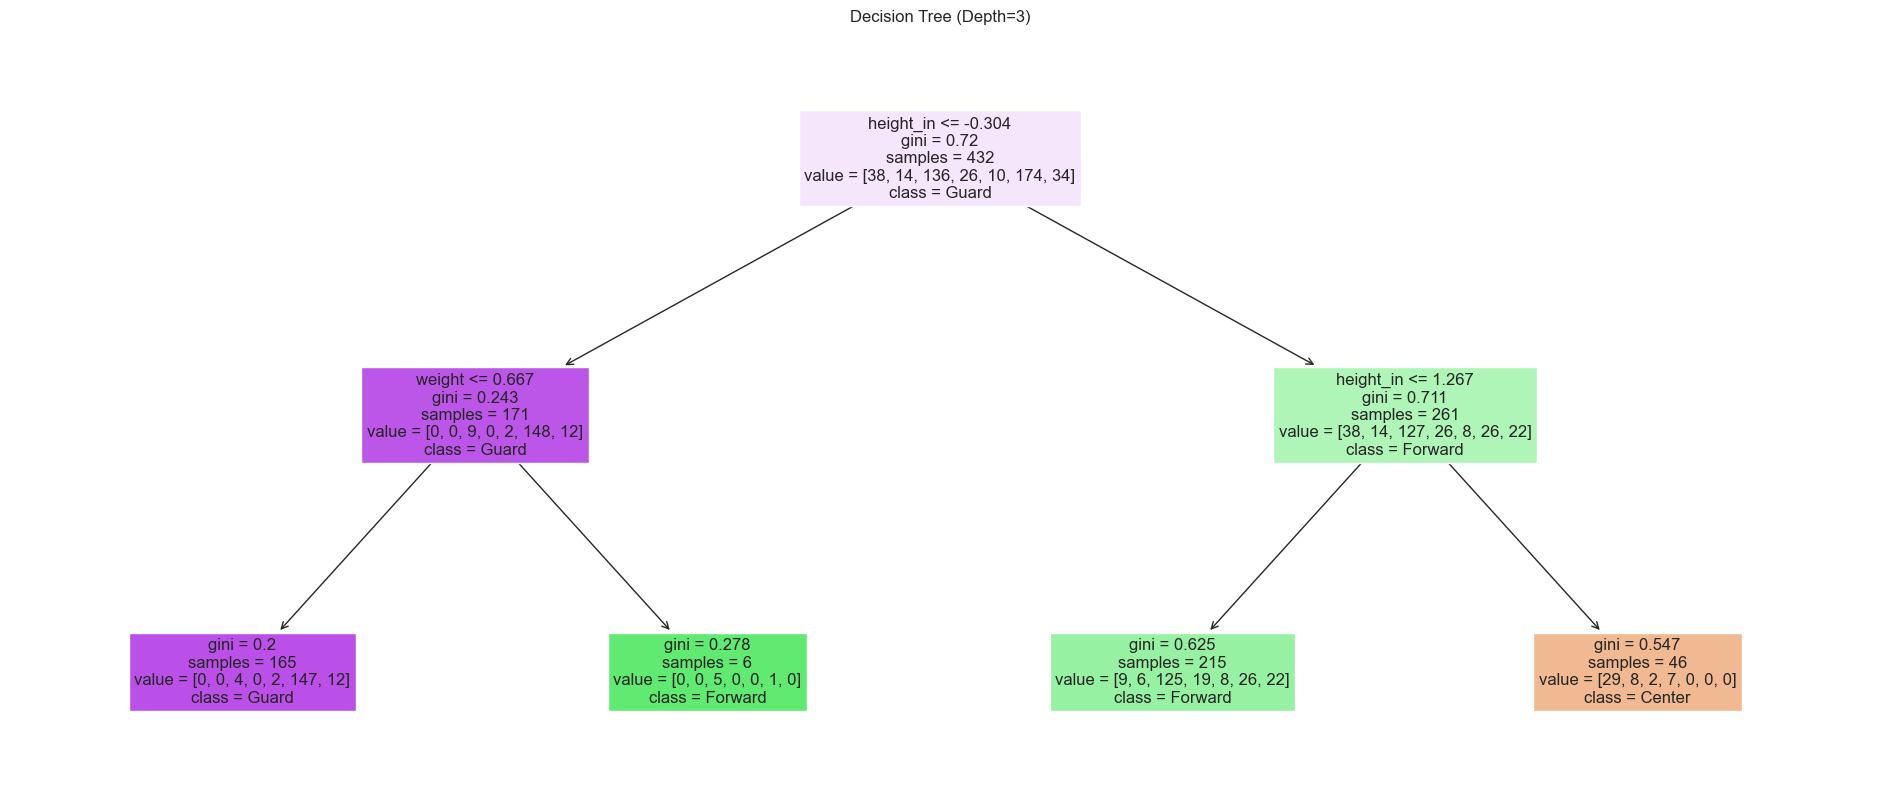

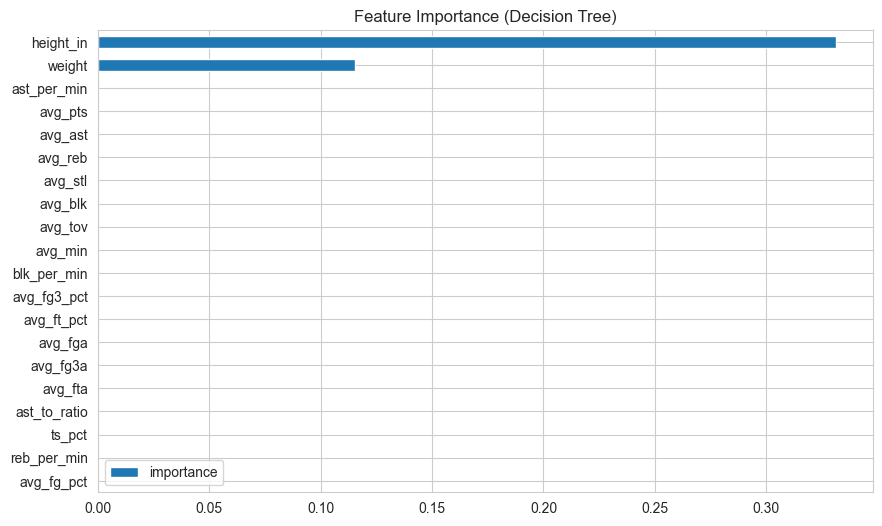

In [31]:
# Plot decision tree
plt.figure(figsize=(24, 10))
plot_tree(dtree, feature_names=X.columns, class_names=dtree.classes_, filled=True, fontsize=12)
plt.title("Decision Tree (Depth=3)")
plt.show()

# Permutation-based feature importance
r = permutation_importance(dtree, X_test_scaled, y_test, n_repeats=10, random_state=42)
imp_df = pd.DataFrame({'importance': r.importances_mean}, index=X.columns)
imp_df.sort_values(by='importance', ascending=True).plot(kind='barh', figsize=(10, 6), title='Feature Importance (Decision Tree)')
plt.show()


Visualization and Feature Importance

The tree structure visualized shows that the most important early split is by height and then by weight. The first split separates "Guard"-like players (shorter) from "Forward"-like and "Center"-like players (taller). Further splits make the predictions more specific based on physical attributes.

Additionally, permutation importance analysis confirmed that height, weight, and avg_reb were among the most important features.

Not only does this model have strong predictive power, but it also has interpretability, which is crucial to understand how physical and statistical characteristics drive position classification.

## Next Steps & Discussion

#### Summary of Findings

In my models classification of NBA player positions, the performance of all the models used was better than that of the baseline dummy classifier, demonstrating that they could learn useful patterns from statistic features as well as physical features. Models listed by performance from top are: Decision Tree, Random Forest, K-Nearest Neighbors, and Logistic Regression.

Key Findings:

1. Performance of Decision Tree Model
The top performance was achieved by the Decision Tree model with a depth of 4, which had a test accuracy of 69.7% and the best weighted average f1-score of 0.70. The model achieved high classification values for strong classes like "Guard" (f1-score: 0.87) and "Forward" (f1-score: 0.65), and also offered interpretability in the form of visual tree plots and permutation-based feature importance.

2. Random Forest Effectiveness:
Random Forest model was also highly competitive with identical 69% accuracy and strong performance on prevailing classes. Its hybrids and underrepresented role predictions like "Guard-Forward" and "Forward-Guard" were always poor across all models and can be explained due to class imbalance and vagueness of labels.

3. KNN Model Weaknesses and Strengths:
KNN achieved 69% test accuracy and weighted f1-score of 0.66 with strong performance on "Forward" and "Guard" positions but completely failed in minority position classification. This reflects the susceptibility of KNN to multi-class imbalanced data and the need for further tuning, such as using distance weighting or SMOTE-based oversampling.

4. Logistic Regression Trade-offs
Logistic Regression performed the poorest among all the models with the test accuracy at 62% and weighted f1-score at 0.57. It was its linearity that hindered its ability to pick complex patterns, specifically in hybrid position classification. Even so, it provided valuable indications of feature contribution via coefficient examination.


#### Next Steps / Improvements

To further improve the accuracy and real-world applicability of the player position classification models, I would recommend the following:

- Clarifying Positional Labels:
One of the most prominent limitations observed in this project was the fuzziness between a few of the hybrid positions, i.e., "Forward-Guard" and "Guard-Forward". These positions overlap in playstyle and game role and are difficult to distinguish based on statistical features alone. This inherent ambiguity places a ceiling on model performance, with an upper bound on accuracy of around 70%.

- Class Imbalance and Underrepresented Roles:
Some positions, such as "Forward-Center" and "Center-Forward", were extremely under-sampled in the data, leading to extremely low precision and recall measures—often zero. Expanding the dataset to include more players in each positional position could act to counteract this imbalance and maximize generalizability. 

- Future Data Collection:
With access to a larger and more diverse set of players—especially from recent seasons or across leagues globally—the model could be additionally trained to capture fine-grained differences between roles and playing styles. 

- Real-World Application Context:
This predictive model is eventually supposed to be a tool to assist coaches and teams. It gives data-driven recommendations on which position a player is most statistically suited to, both from a physical and on-court playing standpoint. Position assignment finally, however, needs to consider team strategy, lineup needs, and coaching philosophy.

By addressing class clarity, sample imbalance, and improving future data coverage, this modeling framework can become a more effective scouting and strategy tool for player role identification.


#### Conclusion

This project aimed to classify the positions of NBA players using a data-based approach by taking into account physical attributes and in-game playing statistics. By analyzing a collection of features—height, weight, rebounds, assists, and shooting percentages—the project explored the way statistical profiles relate to positional functions in modern basketball. The findings show the potential of machine learning to help teams and coaches determine player versatility and strategic choices. Despite constraints such as label ambiguity and class imbalance, the model provides a good foundation for future growth, especially with enhanced data availability. Ultimately, the aim is not to rigidly define positions, but to offer thought-provoking contributions that enhance tactical and coaching decisions.